# Signal Mapping Refinement

This notebook will introduce the concept of signal mapping refinement (re-squiggling).
This aligns signal with sequence via a table of expected signal levels.
After a signal mapping has been refined it becomes more comparable to other reads enabling powerful downstream analyses.

#### Imports

In [1]:
import logging
from pathlib import Path

import pod5
import polars as pl
import plotnine as p9
import patchworklib as pw

import remora
from remora import io, refine_signal_map, util

p9.theme_set(p9.theme_minimal() + p9.theme(figure_size=(10, 3)))

<Figure size 100x100 with 0 Axes>

## Load Test Data

A test read is loaded as shown in the `basic_read_plotting` notebook.

In [2]:
# load data sources
test_data_root = Path("..") / "tests" / "data"
pod5_fh = pod5.Reader(test_data_root / "can_reads.pod5")
bam_fh = io.ReadIndexedBam(test_data_root / "can_mappings.bam")
# load  test read
read_id = "6e37823a-9398-4be8-b111-65cab029f4e0"
pod5_read = next(pod5_fh.reads(selection=[read_id]))
bam_read = bam_fh.get_first_alignment(read_id)
io_read = io.Read.from_pod5_and_alignment(pod5_read, bam_read)

Indexing BAM by read id: 14 Reads [00:00, 9338.46 Reads/s]


## Load K-mer Table

Next a k-mer table is loaded into a signal mapping refiner object.
The k-mer table contains a mapping between each k-mer and the expected signal level for that sequence.
A k-mer is a short fixed length of nucleotides.
For example the 3-mers (k=3) are `AAA, AAC, AAG, ..., TTT`.
This table is used in Remora to produce consistent scaling and signal to sequence mappings, making reads more comparable.
In `Tombo`, `Nanoraw` and other previous Nanopore software, the algorithms computing optimal signal to sequence mapping given a k-mer table were referred to as re-squiggling.
This term has been deprecated here in favor of hopefully more precise language.
K-mer tables are available from the [kmer_models github repository](https://github.com/nanoporetech/kmer_models).
The tables are generated with proprietary internal software.

In [3]:
level_table = test_data_root / "levels.txt"
sig_map_refiner = refine_signal_map.SigMapRefiner(
    kmer_model_filename=level_table,
    do_rough_rescale=True,
    scale_iters=0,
    do_fix_guage=True,
)

#### Expected Levels Normalization

The `do_fix_gauge` option specifies that the expected signal values should be adjusted to have a mean of approximately `0` and a standard deviation of approximately `1`.
This is done with the median and MAD to produce more robust results than mean and standard deviation.
This allows users to input expected levels in any scaling (e.g. pA or DAC scaling) and they will be converted to the same approximate scale as Nanopore produced k-mer models for easier comparison when `do_fix_gauge=True` is set.

## K-mer Dominant Position

After reading and validating the k-mer table, Remora performs several additional steps to produce robust results from the k-mer table.
The "dominant" position within the k-mer is determined by the Kruskal-Wallis H-test statistic which tests for non-random ordering of the bases at each position within the k-mer when sorted by expected signal level.
This is visualized in the next cell.
Using the loaded DNA Kit 14 9-mer table and selecting the most informative sub-5-mer, we can see that position `2` within the 5-mer shows the most non-random ordering.

The identified "dominant position" is used as the position within the k-mer at which the expected level, and thus reads signal, is precisely assigned.
Note that this procedure is deterministic and completed each time the k-mer table is loaded.

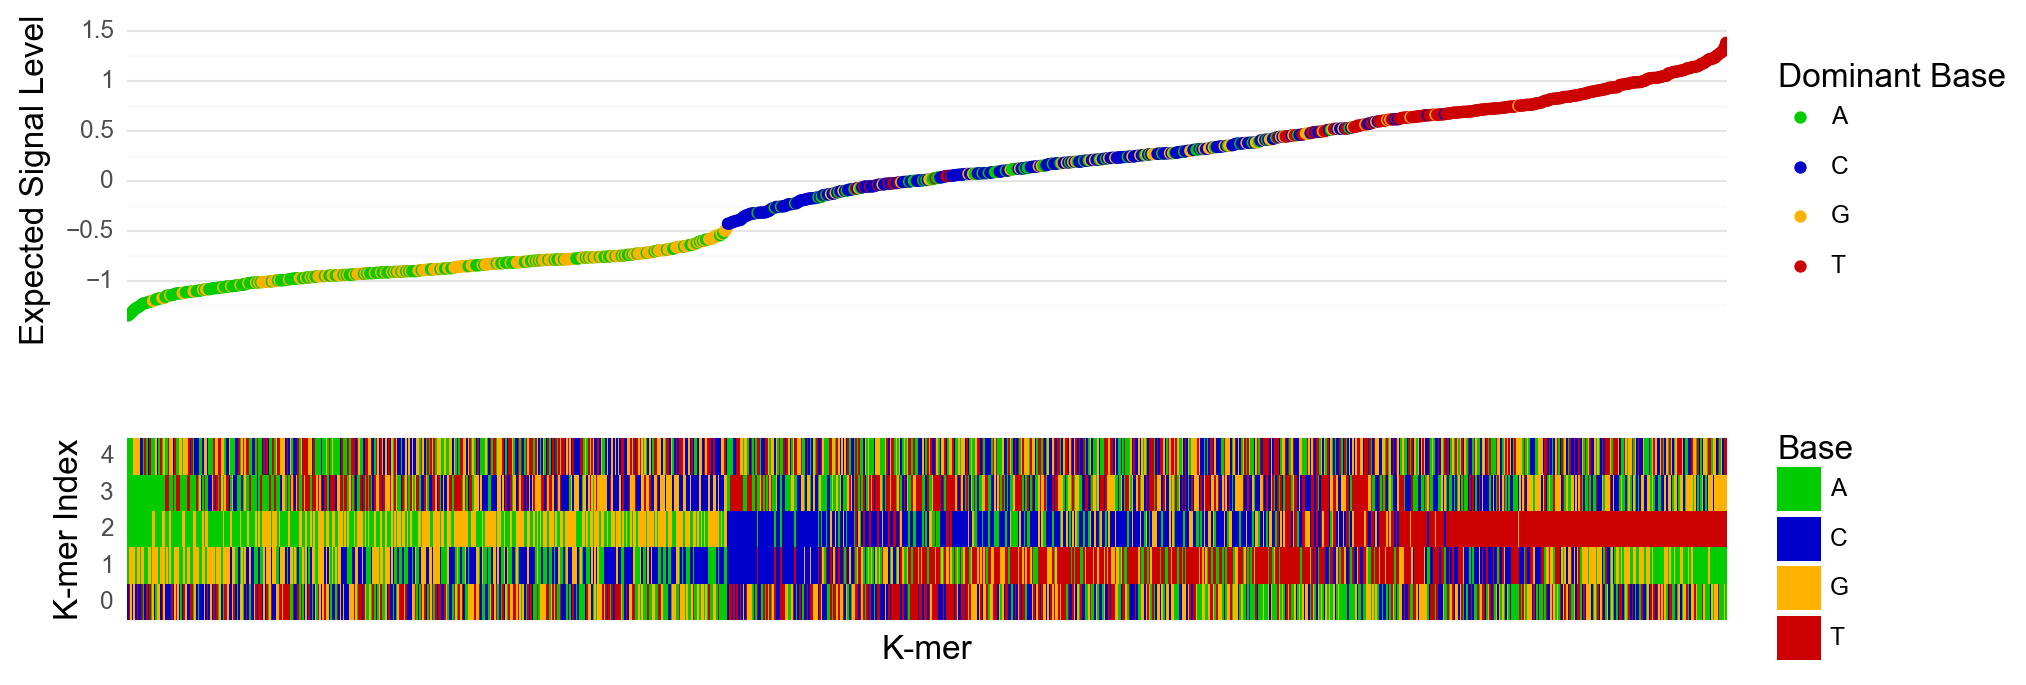

In [4]:
sub_kmers_df = sig_map_refiner.get_sub_kmer_table(5)
pw.load_ggplot(
    p9.ggplot(sub_kmers_df)
    + p9.geom_point(
        p9.aes(x="K-mer", y="Expected Signal Level", color="Dominant Base")
    )
    + p9.scale_x_discrete(limits=sub_kmers_df["K-mer"])
    + p9.scale_color_manual(io.BASE_COLORS)
    + p9.theme(
        axis_text_x=p9.element_blank(),
        panel_grid_major_x=p9.element_blank(),
        figure_size=(8, 1.5),
        axis_title_x=p9.element_blank(),
        plot_margin=0.01,
    )
) / pw.load_ggplot(
    p9.ggplot(
        sub_kmers_df.with_columns(
            sub_kmers_df["K-mer"].apply(lambda s: list(s)).alias("Base")
        )
        .with_columns(
            pl.col("Base")
            .apply(lambda bases: list(range(len(bases))))
            .alias("K-mer Index")
        )
        .explode("Base", "K-mer Index")
    )
    + p9.geom_tile(p9.aes(x="K-mer", y="K-mer Index", fill="Base"))
    + p9.scale_x_discrete(limits=sub_kmers_df["K-mer"])
    + p9.scale_fill_manual(io.BASE_COLORS)
    + p9.theme(
        axis_text_x=p9.element_blank(),
        panel_grid_major_x=p9.element_blank(),
        figure_size=(8, 1),
        plot_margin=0.01,
    )
)

## Plot with levels

Now that we have a k-mer table loaded, what can we do with it?

The simplest operation is to plot the from a read along with the expected signal levels derived from either basecalls or reference sequence.
This is often useful, but note how the expected levels are often offset from the signal assigned to the basecall or reference sequence.
We will go over addressing this in the next section.

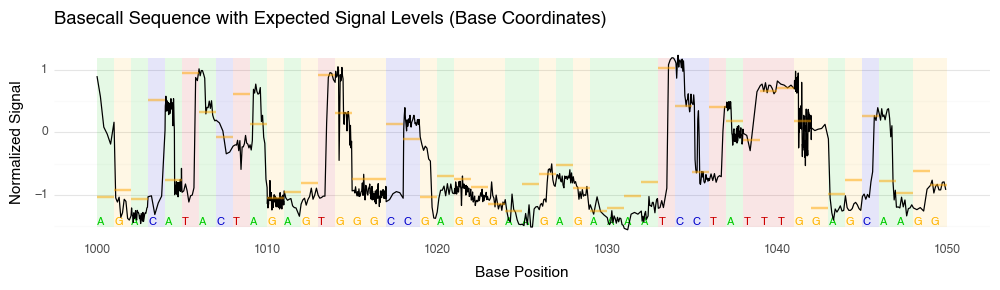

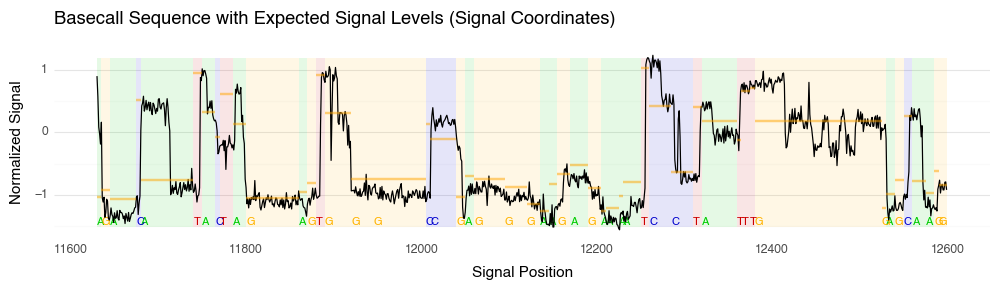

In [5]:
start_base, end_base = 1_000, 1_050
start_of_basecalls = io_read.extract_basecall_region(
    start_base=start_base, end_base=end_base
)
model_levels = sig_map_refiner.extract_levels(util.seq_to_int(io_read.seq))
print(
    start_of_basecalls.plot_on_base_coords(
        levels=model_levels[start_base:end_base]
    )
    + p9.ggtitle(
        "Basecall Sequence with Expected Signal Levels (Base Coordinates)"
    )
)
print(
    start_of_basecalls.plot_on_signal_coords(
        levels=model_levels[start_base:end_base]
    )
    + p9.ggtitle(
        "Basecall Sequence with Expected Signal Levels (Signal Coordinates)"
    )
)

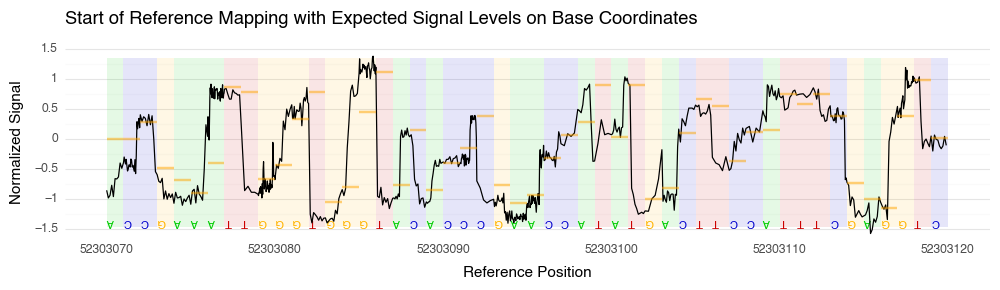

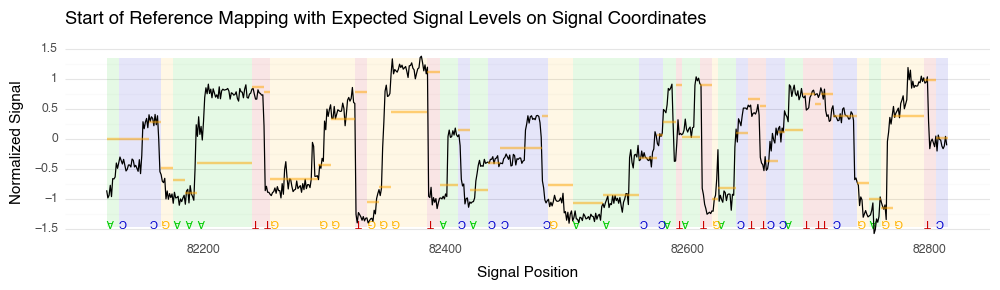

In [6]:
start_of_mapping = io_read.extract_ref_reg(
    io_read.ref_reg.adjust(end_adjust=50 - io_read.ref_reg.len)
)
ref_model_levels = sig_map_refiner.extract_levels(
    util.seq_to_int(io_read.ref_seq)
)
if io_read.ref_reg.strand == "-":
    ref_model_levels = ref_model_levels[::-1]
print(
    start_of_mapping.plot_on_base_coords(levels=ref_model_levels[:50])
    + p9.ggtitle(
        "Start of Reference Mapping with Expected Signal Levels on Base Coordinates"
    )
)
print(
    start_of_mapping.plot_on_signal_coords(levels=ref_model_levels[:50])
    + p9.ggtitle(
        "Start of Reference Mapping with Expected Signal Levels on Signal Coordinates"
    )
)

## Signal Mapping Refiner Options

In the signal plots above the signal is assigned to the basecalls via the "move table".
The move table holds the positions where the basecalling neural network emits bases and is not optimized to match the expected signal level locations.
The primary aim of the signal mapping refiner is to adjust the signal scaling and the signal to sequence mapping to more closely match the expected signal levels.
This section will give details on the various options for this procedure.

#### Signal re-scaling

The above processing steps interrogate and adjust the k-mer table.
Options are also available for how the k-mer table is used to adjust signal and the signal to sequence mapping for a read.

The `do_rough_rescale` option performs a scaling update given an approximate sequence to signal mapping.
The move table provided from the basecaller provides this approximate mapping.
While this mapping generally assigns bases at approximately the correct cadence (matching slower or faster local translocation speed), the signal assigned to a base does not generally match well with the expected signal levels from the k-mer table.
Adjusting the sequence to signal mapping will be discussed in the next section.

The rough re-scaling algorithm compares the quantiles of signal sampled from each base of the move table to quantiles of the expected levels extracted from the read/reference sequence.
This produces a scaling update for a read which generally matches more closely to ideal scaling and has shown to improve modified base model accuracy.

After precise signal to sequence mapping refinement (described below) it is possible to re-scale signal with a direct regression of expected to observed signal levels.
This is in contrast to rough re-scaling where expected and observed signal levels are not found in direct correspondence.
This re-scaling is performed if the `scale_iters` option is set to `1` or greater.
The number of iterations between precise re-scaling and signal mapping refinement is set with the `scale_iters` option.

#### Precise Signal to Sequence Mapping Refinement

Precise signal to sequence mapping refinement is the process of fitting signal breakpoints to optimally match the signal within the breakpoints to expected signal levels.
This process is common completed by dynamic time warping (DTW) or other dynamic programming solutions.
Precise signal to sequence mapping refinement is not used in any production Remora modified base models (or compatible with Dorado model export), but is useful for plotting and signal metric extraction.
Thus setting `do_rough_rescale=True` and `scale_iters=0` is the recommended setting when performing signal metric analysis.

Remora provides options to obtain a precise sequence to signal mapping via a dynamic programming step.
Setting the `scale_iters` option to `-1` skips this step.
Setting the value to `0` performs a single round of precise signal mapping.
Setting the value to `1` or greater iterates between precise signal mapping and precise signal re-scaling the specified number of times.

The `SigMapRefiner.algo` option provides two dynamic programming implementations to complete the precise mapping.
Both algorithms take the input signal to sequence mapping and define a band extending `half_bandwidth` bases either side over which to search for the optimal mapping.
Larger values allow for a larger search space potentially identifying more optimal mappings, but at a higher computational cost.
The more simple `algo="Viterbi"` option performs a simple dynamic programming matching with squared error loss between each expected level and the input signal.
No skipped levels are allowed.

The more complex and default `algo=dwell_penalty` option adds a penalty for the assignment of a small number of signal points to an expected level.
This is generally the recommended algorithm as a standard Viterbi assignment often assigns a single signal point to many bases, and giving a poor result at the base level.
Loss is generally taken as the average over signal points as base averaging losses are more computationally expensive and produce less accurate breakpoints.
The `sd_params` option allows the specification of the short dwell algorithm via more interpretable parameters.
This options should be a 3-tuple containing the `target` dwell (in number of signal points), the `limit` of the values at which to apply a penalty, and the `weight` of quadratic decay from a dwell of `0` to `target`.
The default is set with the value `(4, 3, 0.5)` and is optimized for Kit 14 DNA data, but works reasonably well for a range of data types.
Alternatively the `sd_arr` parameter can directly set the penalty for each dwell length.
Note that there is a constant order compute penalty for each additional value in the `sd_arr` array (or higher value or `limit`).

The next cells show how signal mapping refinement is performed on both basecall and reference mappings.
Signal is then visualized against the modeled levels.
Note how the assigned signal now matches the expected levels more closely.
Also note that these signal mappings overwrite the previous values so the move table is no longer available.
If a user requires the move table signal mapping the read should be reloaded.

In [7]:
# silence DEBUG messages from signal refinement
logging.getLogger("Remora").setLevel(logging.INFO)
io_read.set_refine_signal_mapping(sig_map_refiner, ref_mapping=False)
io_read.set_refine_signal_mapping(sig_map_refiner, ref_mapping=True)

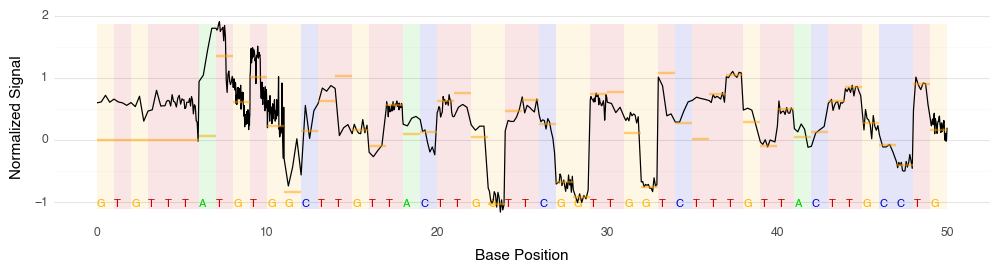

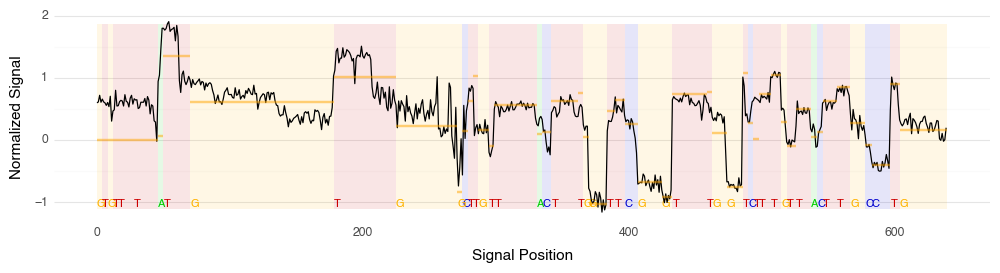

In [8]:
start_of_basecalls = io_read.extract_basecall_region(end_base=50)
print(start_of_basecalls.plot_on_base_coords(levels=model_levels[:50]))
print(start_of_basecalls.plot_on_signal_coords(levels=model_levels[:50]))

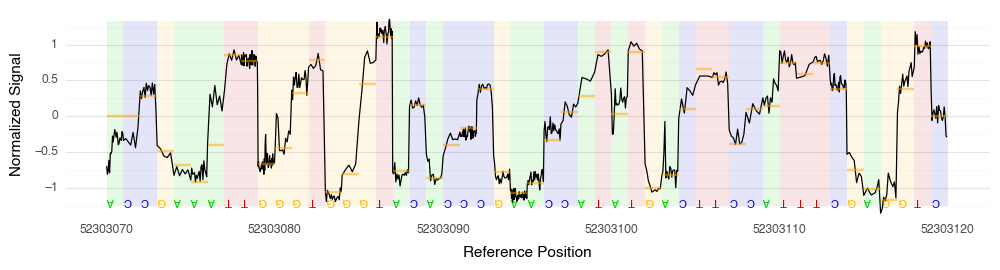

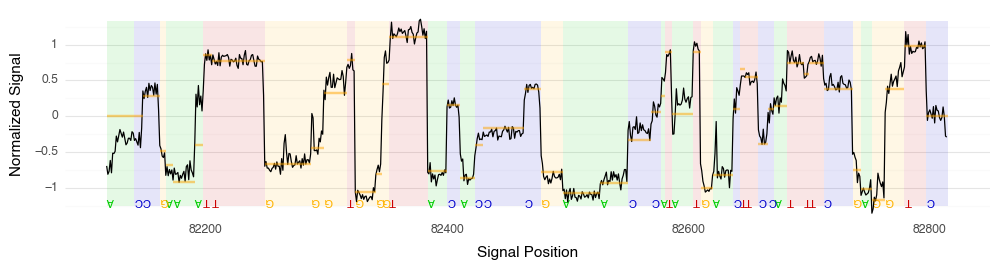

In [9]:
start_of_mapping = io_read.extract_ref_reg(
    io_read.ref_reg.adjust(end_adjust=50 - io_read.ref_reg.len)
)
print(start_of_mapping.plot_on_base_coords(levels=ref_model_levels[:50]))
print(start_of_mapping.plot_on_signal_coords(levels=ref_model_levels[:50]))

Alignment plotting is also available after signal mapping refinement.
The beginning of a signal mapping can be a bit distorted as expected levels at the edge of a mapping (where the full k-mer is not available) are set to `0`.
This can be seen in the above plots, where the expected levels for the first several bases are a single flat line.
This results in slightly distorted mapping shown in the alignment plotting shown below.

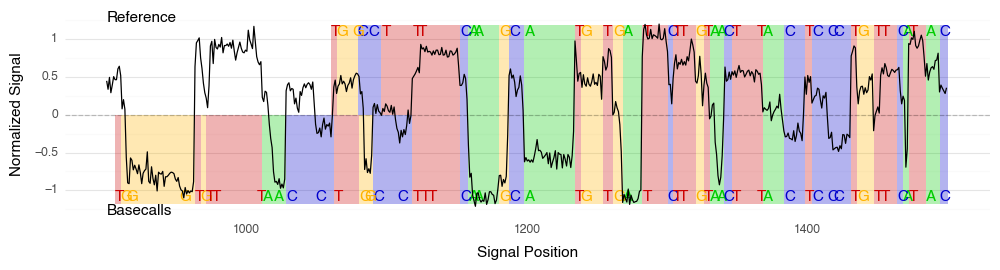

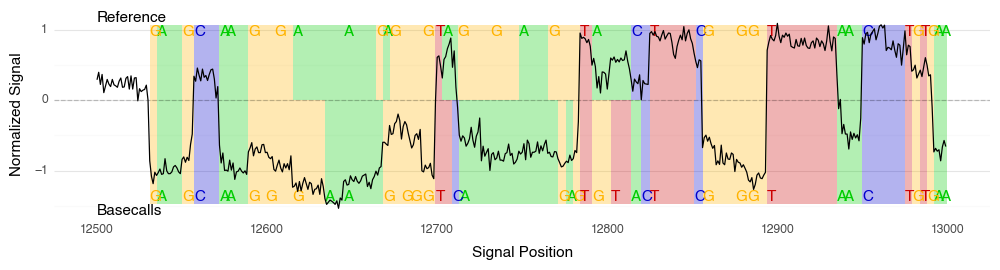

In [10]:
print(io.plot_align(io_read, 900, 1500))
print(io.plot_align(io_read, 12_500, 13_000))